Update fastai, mount the drive, and setup the path

In [1]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0    397      0 --:--:-- --:--:-- --:--:--   397
Updating fastai...
Done.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [0]:
from fastai import *
from fastai.vision import *

In [0]:
path = Path('/content/gdrive/My Drive/fellowship/food-101')

# Initial Experimentations

In this notebook some initial experimentations will be performed on a subset of the data to make sure things are working fine. 

Working with a subset of the data is very important as the size of the dataset is huge and experimenting with the full dataset will consume a lot of time with no additional benefit. 

The following tasks will be done throughout this notebook:
1. Download and extract the data.
2. Read, split, and label the data.
3. Data augmentation: experiment with different transformations to decide the suitable ones and their respective parameters.
4. Architecture: experiment with different architectures and compare using appropriate metrics.
5. Plan the steps for the project with the complete dataset.

## Download data

In [0]:
path = Path('/content/gdrive/My Drive/fellowship')

In [0]:
untar_data?

In [0]:
untar_data(URLs.FOOD, dest=path, force_download=True)

PosixPath('/content/gdrive/My Drive/fellowship/food-101')

In [0]:
path = Path('/content/gdrive/My Drive/fellowship/food-101')

In [0]:
(path/'images').ls()

[PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/samosa'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/sashimi'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/spring_rolls'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/panna_cotta'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/greek_salad'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/foie_gras'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/tacos'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/pad_thai'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/pulled_pork_sandwich'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/crab_cakes'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/risotto'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/steak'),
 PosixPath('/content/gdrive/My Drive/fellowship/food-101/images/falafel')

## Read/Split/Label the data

It is very important to split the data into training and validation sets according to the procedures followed by the original authors in order to fairly compare the obtained results in the end. 

We also need to work on a subset of the data. As the number of classes is high (101), it doesn't make sense to split by a percentage as the training samples per class will be low. Instead, we select a subset of classes. We chose to experiment with 5 classes, which is a good size to evaluate the performance and small enough to run the experiments within a reasonable time. 

For faster experiments, we may select percentage of samples within the selected 5 classes.


In [6]:
train_df = pd.read_csv(path/'train.txt', header=None)
test_df = pd.read_csv(path/'test.txt', header=None)

train_df['valid']=0
test_df['valid']=1

train_df.columns = ['name', 'valid']
test_df.columns = ['name', 'valid']

train_df['label'] = train_df.name.apply(lambda o: Path(o).parts[0])
test_df['label'] = test_df.name.apply(lambda o: Path(o).parts[0])

df = train_df.append(test_df)
print(len(df))
df.head()

101000


name  valid      label
0  apple_pie/1005649      0  apple_pie
1  apple_pie/1014775      0  apple_pie
2  apple_pie/1026328      0  apple_pie
3  apple_pie/1028787      0  apple_pie
4  apple_pie/1043283      0  apple_pie

Let's start with a small subset of the data. We'll start with 5 classes to do the experiments and then generalize to full dataset.

In [7]:
classes = list(df.label.unique()[:5]); classes

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [8]:
df = df[df.label.isin(classes)]
len(df)

5000

In [12]:
il = ImageList.from_df(df, path/'images', suffix=".jpg"); il

ImageList (5000 items)
Image (3, 512, 308),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /content/gdrive/My Drive/fellowship/food-101/images

In [0]:
#il = il.use_partial_data(sample_pct=0.03, seed=42); pil

In [13]:
s = il.split_from_df(col=1); s

ItemLists;

Train: ImageList (3750 items)
Image (3, 512, 308),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /content/gdrive/My Drive/fellowship/food-101/images;

Valid: ImageList (1250 items)
Image (3, 512, 512),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 382),Image (3, 342, 512)
Path: /content/gdrive/My Drive/fellowship/food-101/images;

Test: None

In [14]:
src = s.label_from_df(cols=2); src

LabelLists;

Train: LabelList (3750 items)
x: ImageList
Image (3, 512, 308),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /content/gdrive/My Drive/fellowship/food-101/images;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 384),Image (3, 512, 384),Image (3, 512, 382),Image (3, 342, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /content/gdrive/My Drive/fellowship/food-101/images;

Test: None

## Transformaitons

Let's start with the default  transformations of fastai and try to improve from there. 

In [0]:
tfms = get_transforms()

In [0]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=64, no_check=True)
        .normalize(imagenet_stats))

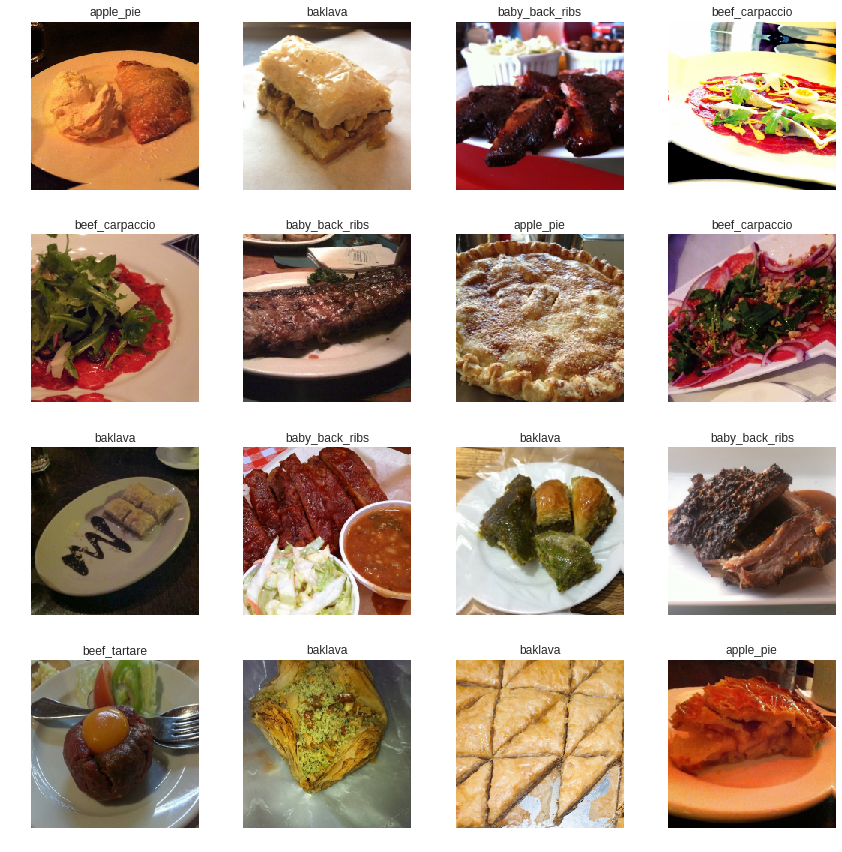

In [0]:
data.show_batch(rows=4, figsize=(12,12))

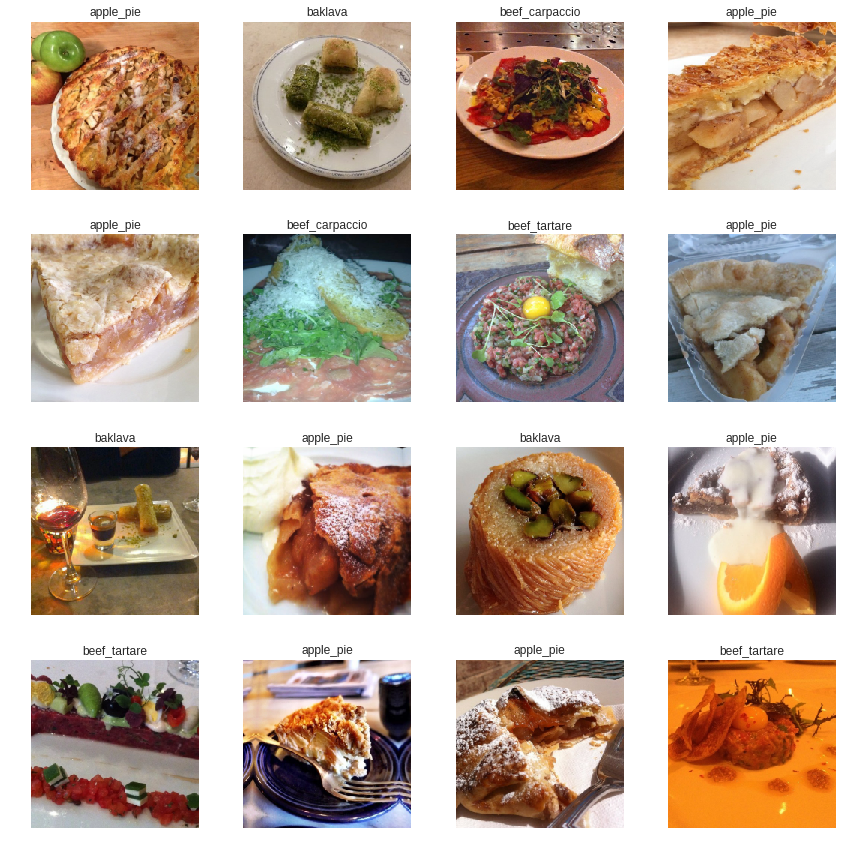

In [0]:
data.show_batch(rows=4, figsize=(12,12))

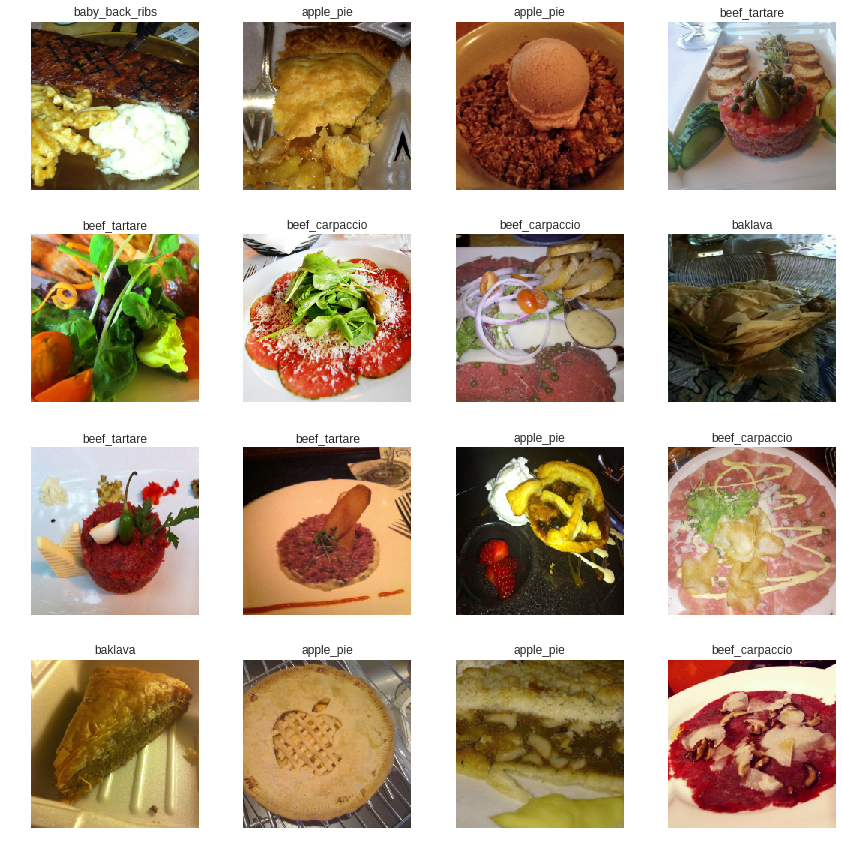

In [0]:
data.show_batch(rows=4, figsize=(12,12))

These seems not professional photos. We notice cases of over-exposure and under-exposure. However, we need to keep the transformations as it will help for the generalization. So, we'll limit the range of brightness and contrast to the lower side.
We can increase the rotation and keep the zoom to minimal as most photos are close-ups to the main subject. After some experiments, we decided to stick with the below settings for transformations. 


In [0]:
xtra = [brightness(change=(0.45,0.6), p=0.5), contrast(scale=(0.95,1.1), p=0.5)]
tfms = get_transforms(max_rotate=30., max_zoom=1.1, max_warp=0.3, p_affine=0.75, xtra_tfms= xtra)

In [0]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

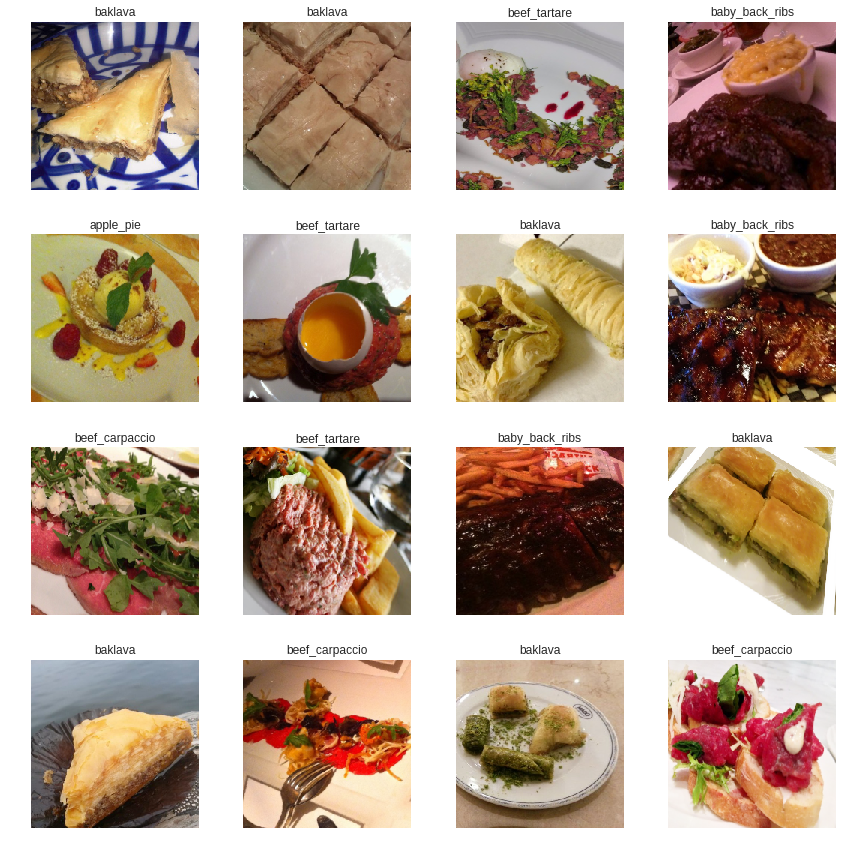

In [0]:
data.show_batch(rows=4, figsize=(12,12))

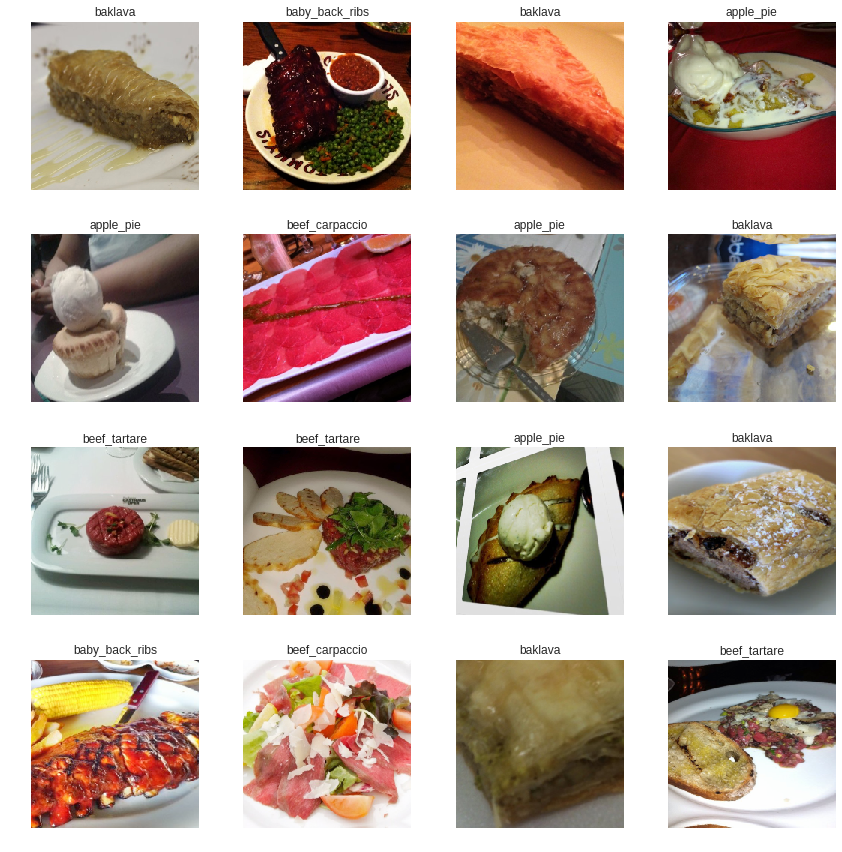

In [0]:
data.show_batch(rows=4, figsize=(12,12))

The results of the chosen transformations look promising so we will stick with them.

## Architecture

We can apply transfer learning in this case as the images are of similar nature to some of ImageNet classes. Transfer learning allows for much faster training phase and a very good performance. 

We'll test few models with 1 epoch while the backbone is frozen and 3 epochs while the backbone is unfrozen. The idea is to choose a model the produces the highest accuracy and that can accommodate the big chunk left of classes while being reasonable in terms of size and training time for this project.


### restnet18

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], pretrained=True).to_fp16();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


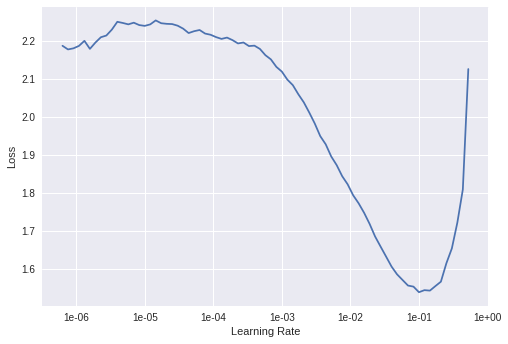

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, max_lr=1e-02)

In [0]:
learn.unfreeze();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


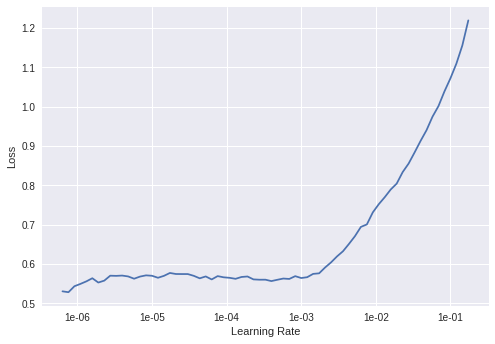

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=slice(1e-04, 1e-02))

This seems promising for 5 classes. But, we want to go for better architectures and compare the resutls.

### resnet34

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy], pretrained=True).to_fp16();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 84762832.03it/s]


In [0]:
learn.fit_one_cycle(1, max_lr=1e-02)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


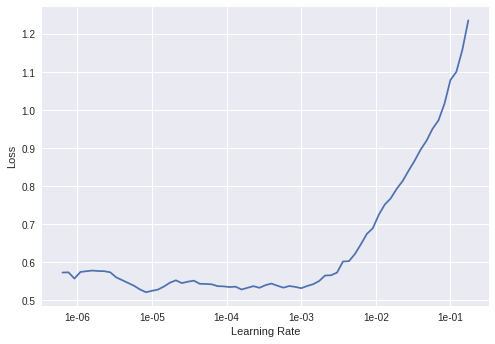

In [0]:
learn.unfreeze();
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=slice(1e-05, 1e-03))

This is not much better than resnet18. Let's see how the resnet50 will perform.

### resnet50

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 95127344.56it/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


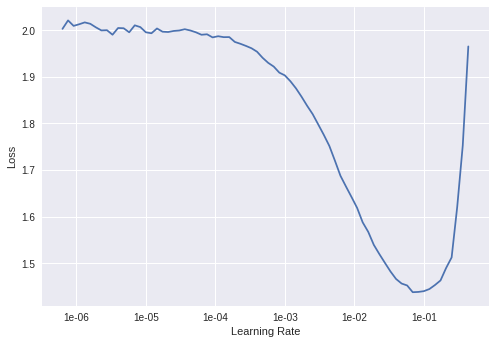

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, max_lr=1e-02)

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


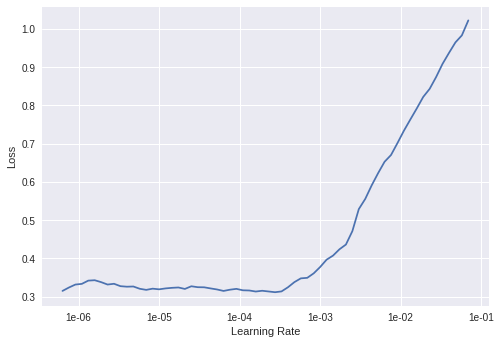

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=slice(3e-06, 3e-04))

This is much better. 

Especially that we are only using a very small portion of the dataset.

## Interpretation

In [0]:
intrp = ClassificationInterpretation.from_learner(learn)

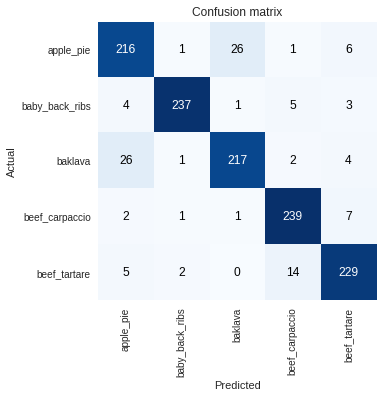

In [0]:
intrp.plot_confusion_matrix()

Looking at the confusion matrix, the model is doing very well for certain classes. But not doing great for others, namely, `apple_pie` and `baklava`, which is expected given they might be confusing for humans in some of the phots. 

So, we expect that the model will perform well on the classes that have distinctive features. However, it might struggle with classes that have common features or with images that have multiple items.


In [0]:
intrp.most_confused()

[('apple_pie', 'baklava', 26),
 ('baklava', 'apple_pie', 26),
 ('beef_tartare', 'beef_carpaccio', 14),
 ('beef_carpaccio', 'beef_tartare', 7),
 ('apple_pie', 'beef_tartare', 6),
 ('baby_back_ribs', 'beef_carpaccio', 5),
 ('beef_tartare', 'apple_pie', 5),
 ('baby_back_ribs', 'apple_pie', 4),
 ('baklava', 'beef_tartare', 4),
 ('baby_back_ribs', 'beef_tartare', 3),
 ('baklava', 'beef_carpaccio', 2),
 ('beef_carpaccio', 'apple_pie', 2),
 ('beef_tartare', 'baby_back_ribs', 2),
 ('apple_pie', 'baby_back_ribs', 1),
 ('apple_pie', 'beef_carpaccio', 1),
 ('baby_back_ribs', 'baklava', 1),
 ('baklava', 'baby_back_ribs', 1),
 ('beef_carpaccio', 'baby_back_ribs', 1),
 ('beef_carpaccio', 'baklava', 1)]

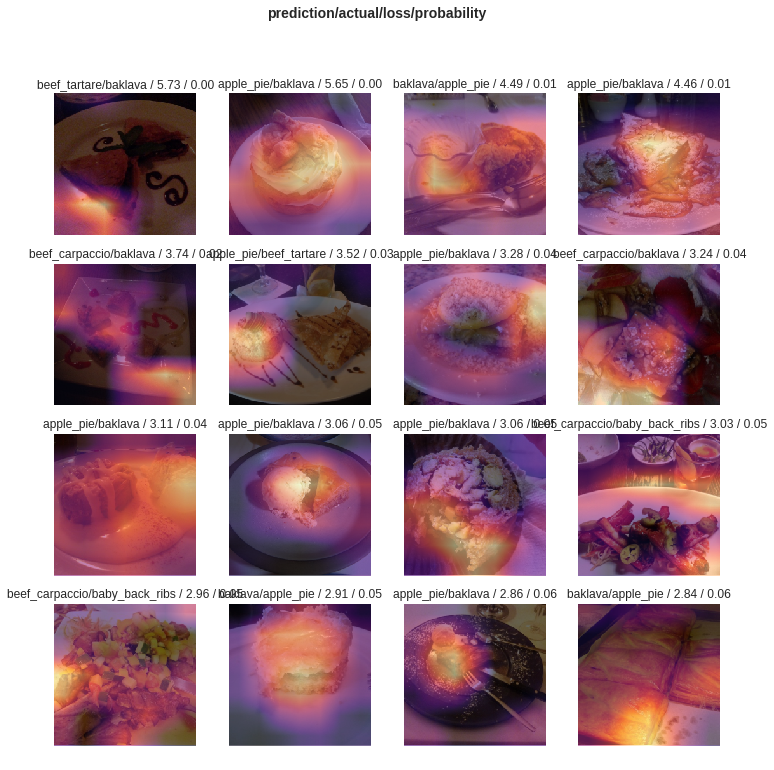

In [0]:
intrp.plot_top_losses(k=16)

From the above figure, we see that although the model does focus on the main object it still can't differentiate between the two confusing classes.

In [0]:
accuracy(*learn.TTA())

tensor(0.9200)

Using Test Time Augmentations (TTA) definitely helps and we shall use it as long as the application can tolerate the time taken for processing.

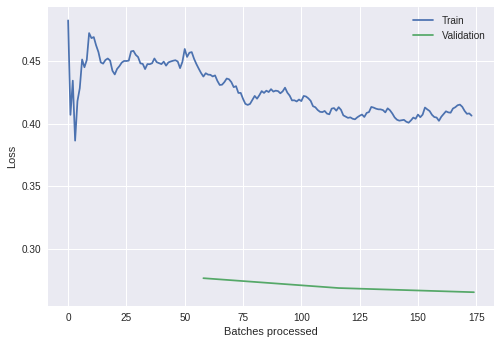

In [0]:
learn.recorder.plot_losses()

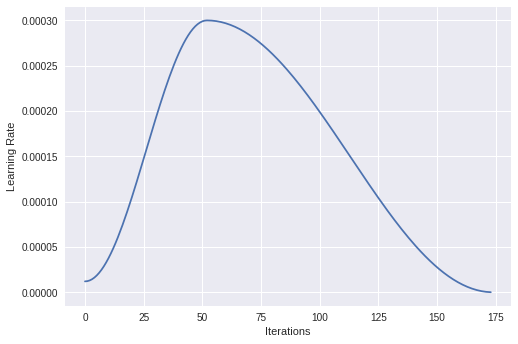

In [0]:
learn.recorder.plot_lr()

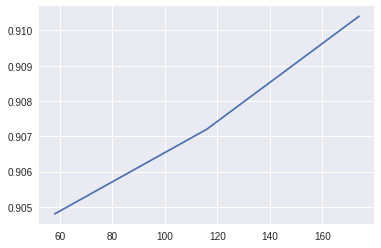

In [0]:
learn.recorder.plot_metrics()

In [0]:
learn.fit_one_cycle(8, max_lr=slice(3e-06, 3e-04))

In [0]:
learn.wd = 0.1

In [0]:
learn.fit_one_cycle(3, max_lr=slice(3e-06, 3e-04))

In [0]:
learn.wd = 1.5

In [0]:
learn.fit_one_cycle(3, max_lr=slice(3e-06, 3e-04))

In [0]:
learn.fit_one_cycle(3, max_lr=slice(3e-06, 3e-04))

In [0]:
accuracy(*learn.TTA())

tensor(0.9328)

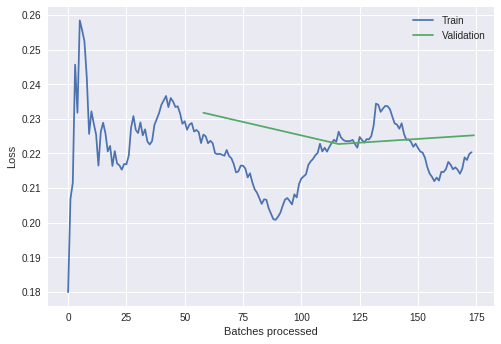

In [0]:
learn.recorder.plot_losses()

## More Transformations

After reviewing few blog posts that emphasize the importance of data augmentation on the performance of models, I decided to revisit this particular aspect. Most important was this [post](https://platform.ai/blog/page/3/new-food-101-sota-with-fastai-and-platform-ais-fast-augmentation-search/) on achieving a new SoTA results on the same dataset. I also decided to stick with the resnet50 as it has performed very well on similar tasks. 

We'll try to add more transformations for data augmentation and see how this affects the performance of the model. 

After some more experimentation, I decided to stick with the below transformations as they resulted in a better performance. The decision reached based on the performance of the model and by visually inspecting the outcome.


In [0]:
xtra = [brightness(change=(0.40,0.63), p=0.75), contrast(scale=(0.95,1.1), p=0.75), crop(size=224, row_pct=(0.3,0.7), col_pct=(0.3,0.7)), 
        squish(scale=(0.80,1.2)), tilt(direction=(0,3), magnitude=(-0.3,0.3)), skew(direction=(0,3), magnitude=(-0.2,0.2))]
tfms = get_transforms(max_rotate=30., max_warp=0.3, max_lighting=None, p_affine=0.75, xtra_tfms= xtra)

In [16]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.6/dist-packages/fastai/basic_data.py:259: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in self.train_ds: 1456,1981
  warn(warn_msg)


In [17]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], pretrained=True, wd=.1, ps=0.5)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 54412700.32it/s]


In [18]:
learn.fit_one_cycle(1, max_lr=1e-02)

In [19]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(3e-06, 3e-04))

In [20]:
accuracy(*learn.TTA())

tensor(0.9208)

This is impressive!

Let's save the model for further exploration.

In [0]:
learn.save('final-model-224-stage2')

Adding more transformations didn't show significant improvement in this experiment. However, it is better to have them as a mean of regularization.  

Next will try to increase the image size and do transfer learning and see the effect.


## Increase image size

In [0]:
data = (src.transform(tfms=tfms, size=512)
        .databunch(bs=16)
        .normalize(imagenet_stats))

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy], pretrained=True, wd=.1, ps=0.5).load('final-model-224-stage2')

In [25]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(3e-06, 3e-04))

This helps increase the performance of the model. However, it increases the training time for each epoch from 2 minutes to 7 minutes!

Although this is promising, but I might drop this option having the size of the dataset is huge.




# The plan



1.   Consider all classes and all images
2.   Use `resnet50` architectrue
3.   Use the set of transformations that yielded the best results with size 224
4.   Monitor over-fitting along the way and use a mix of regularizaiton techniques to overcome this problem
5.   Do transfer learning with the full size (512) (optional)
6.   Finally, use TTA to assess the final performance of the model





